In [9]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf1.Session(config=config)

2024-12-07 22:06:15.991008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 22:06:16.119138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24217 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:1a:00.0, compute capability: 8.9


In [4]:
import pandas as pd
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import backend as K

df = pd.read_csv('FracAtlas/dataset.csv')

# fracture_count가 5인 데이터를 필터링
filtered_data = df[(df['hand'] == 1) & (df['fractured'] == 1)]

# 결과 데이터프레임 출력
filtered_data

2024-12-07 22:05:42.387514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 22:05:42.562142: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 22:05:42.589885: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 22:05:43.247664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

,image_id,hand,leg,hip,shoulder,mixed,hardware,multiscan,fractured,fracture_count,frontal,lateral,oblique
19,IMG0000019.jpg,1,0,0,0,0,0,0,1,1,1,0,0
25,IMG0000025.jpg,1,0,0,0,0,0,0,1,1,0,1,0
44,IMG0000044.jpg,1,0,0,1,1,0,0,1,1,1,0,0
57,IMG0000057.jpg,1,0,0,1,1,0,0,1,1,0,0,1
58,IMG0000058.jpg,1,0,0,1,1,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,IMG0004369.jpg,1,0,0,1,1,0,0,1,1,1,0,0
4074,IMG0004370.jpg,1,0,0,1,1,0,0,1,1,1,0,0
4077,IMG0004374.jpg,1,0,0,0,0,0,0,1,1,0,1,0
4078,IMG0004375.jpg,1,0,0,0,0,0,0,1,1,0,1,0


# 이미지 처리 함수 설명
- 대부분의 함수 사용안하고 몇개의 함수만 사용함...

In [ ]:
def show_image(image, title="Image"):
    """이미지를 Matplotlib로 표시."""
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def load_yolo_annotation(file_path):
    """
    YOLO 어노테이션 파일을 읽어 어노테이션을 반환하는 함수.

    Parameters:
        file_path (str): YOLO 어노테이션 파일 경로.
    
    Returns:
        list: YOLO 어노테이션 값 (class_id, center_x, center_y, width, height).
    """
    with open(file_path, 'r') as f:
        annotations = f.readlines()
    annotations = [line.strip().split() for line in annotations]
    return annotations

def convert_yolo_to_pixel(yolo_annotation, img_width, img_height):
    """
    YOLO 어노테이션 좌표를 픽셀 좌표로 변환하고, 중심을 기준으로 50px씩 박스를 확장하는 함수.

    Parameters:
        yolo_annotation (list): YOLO 어노테이션 값 (class_id, center_x, center_y, width, height).
        img_width (int): 이미지의 가로 길이 (픽셀).
        img_height (int): 이미지의 세로 길이 (픽셀).
    
    Returns:
        tuple: 확장된 박스 좌표 (box_x, box_y, box_w, box_h).
    """
    _, center_x, center_y, width, height = map(float, yolo_annotation)
    
    # YOLO 좌표를 픽셀 좌표로 변환
    box_x = (center_x - width / 2) * img_width
    box_y = (center_y - height / 2) * img_height
    box_w = width * img_width
    box_h = height * img_height

    # 중심 기준으로 50px 확장
    box_x = int(box_x - 15)
    box_y = int(box_y - 15)
    box_w = int(box_w + 30)  # 좌우 50px씩 확장
    box_h = int(box_h + 30)  # 위아래 50px씩 확장
    
    # x, y 좌표가 음수인 경우 0으로 보정하고 보정된 만큼 추가
    x_offset = 0
    y_offset = 0

    if box_x < 0:
        x_offset = -box_x  # 음수일 경우 보정된 양만큼 이동
        box_x = 0
    if box_y < 0:
        y_offset = -box_y  # 음수일 경우 보정된 양만큼 이동
        box_y = 0

    # 박스를 보정된 만큼 이동
    box_x += x_offset
    box_y += y_offset

    return box_x, box_y, box_w, box_h

def draw_bounding_boxes(image, annotations):
    """
    이미지에 여러 YOLO 박스를 그림.
    
    Parameters:
        image (ndarray): 원본 이미지.
        annotations (list of tuples): 각 어노테이션의 좌표 (box_x, box_y, box_w, box_h) 리스트.
    
    Returns:
        image_with_boxes (ndarray): 모든 박스가 그려진 이미지.
    """
    image_with_boxes = image.copy()
    img_width, img_height = image.shape
    for annotation in annotations:
        box_x, box_y, box_w, box_h = convert_yolo_to_pixel(annotation, img_width, img_height)
        cv2.rectangle(image_with_boxes, 
                      (box_x, box_y), 
                      (box_x + box_w, box_y + box_h), 
                      (255, 0, 0), 2)  # 박스 색상 (255, 0, 0), 두께 2
    return image_with_boxes

def crop_bounding_boxes(image, annotations):
    """
    이미지에서 여러 YOLO 박스 영역을 잘라냄.
    
    Parameters:
        image (ndarray): 원본 이미지.
        annotations (list of tuples): 각 어노테이션의 좌표 (box_x, box_y, box_w, box_h) 리스트.
    
    Returns:
        cropped_images (list of ndarray): 잘라낸 이미지 영역 리스트.
    """
    cropped_images = []
    img_height, img_width = image.shape
    for annotation in annotations:
        box_x, box_y, box_w, box_h = convert_yolo_to_pixel(annotation, img_width, img_height)
        cropped_image = image[box_y:box_y + box_h, box_x:box_x + box_w]
        cropped_images.append(cropped_image)
    return cropped_images

# 이미지 파일을 읽고 그레이스케일로 변환하는 함수
def open_image(image_dir, image_file):
    """
    주어진 이미지 파일을 열고, 그레이스케일로 변환하여 반환합니다.

    매개변수:
    - image_dir (str): 이미지 파일이 위치한 디렉토리 경로.
    - image_file (str): 열고자 하는 이미지 파일명.

    반환값:
    - image (numpy.ndarray): 그레이스케일로 변환된 이미지 배열.
    """
    image_path = os.path.join(image_dir, image_file)  # 이미지 파일 경로 생성
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)  # 이미지를 그레이스케일로 변환하여 반환

# JSON 파일을 열고 데이터를 반환하는 함수
def open_json(json_path):
    """
    JSON 파일을 열고, 내용을 반환합니다.

    매개변수:
    - json_path (str): JSON 파일 경로.

    반환값:
    - json_data (dict): JSON 파일에서 읽은 데이터.
    """
    with open(json_path, "r") as f:
        json_data = json.load(f)  # JSON 파일을 열고 내용을 읽어서 반환
    return json_data

# JSON 데이터에서 이미지에 해당하는 폴리곤 좌표를 추출하는 함수
def get_polygon_from_json(json_data, image_filename):
    """
    주어진 JSON 데이터에서 이미지 파일에 해당하는 폴리곤 데이터를 추출하여 반환합니다.

    매개변수:
    - json_data (dict): JSON 데이터.
    - image_filename (str): 폴리곤 정보를 추출할 이미지 파일명.

    반환값:
    - polygons (list of tuple): (x_coords, y_coords)로 이루어진 폴리곤 목록.
    """
    regions = json_data[image_filename]["regions"]  # 이미지에 해당하는 영역 추출
    polygons = []
    for region_id, region_info in regions.items():
        shape_attributes = region_info["shape_attributes"]
        if shape_attributes["name"] == "polygon":  # 폴리곤 형태인 경우
            x_coords = shape_attributes["all_points_x"]
            y_coords = shape_attributes["all_points_y"]
            polygons.append((x_coords, y_coords))  # 폴리곤 좌표를 리스트에 추가
    return polygons

# 주어진 이미지 크기와 동일한 검은색 마스크 이미지를 생성하는 함수
def creat_mask(image):
    """
    주어진 이미지와 동일한 크기의 검은색 마스크 이미지를 생성합니다.

    매개변수:
    - image (numpy.ndarray): 마스크를 생성할 기준 이미지.

    반환값:
    - mask (numpy.ndarray): 검은색으로 채워진 마스크 이미지.
    """
    return np.zeros(image.shape)  # 이미지와 동일한 크기의 0으로 채운 배열을 반환

# 폴리곤을 마스크 이미지에 채우는 함수
def fill_polygons(image, polygons):
    """
    주어진 폴리곤 좌표에 따라 이미지를 채웁니다.

    매개변수:
    - image (numpy.ndarray): 채워질 이미지.
    - polygons (list of tuple): 폴리곤의 x, y 좌표 리스트.

    반환값:
    - image (numpy.ndarray): 폴리곤이 채워진 이미지.
    """
    image = image.copy()  # 원본 이미지를 수정하지 않기 위해 복사본을 사용
    for x_coords, y_coords in polygons:
        pts = np.array([list(zip(x_coords, y_coords))], dtype=np.int32)  # 폴리곤의 x, y 좌표를 합침
        cv2.fillPoly(image, pts, color=255)  # 폴리곤 내부를 흰색으로 채우기
    return image

# 이미지와 JSON 데이터를 기반으로 마스크 이미지를 생성하는 함수
def crate_mask_image(image_dir, json_path, image_file):
    """
    주어진 이미지와 JSON 데이터에서 폴리곤 마스크 이미지를 생성합니다.

    매개변수:
    - image_dir (str): 이미지가 위치한 디렉토리 경로.
    - json_path (str): 폴리곤 정보가 담긴 JSON 파일 경로.
    - image_file (str): 마스크를 생성할 이미지 파일명.

    반환값:
    - mask_image (numpy.ndarray): 폴리곤이 채워진 마스크 이미지.
    """
    json_data = open_json(json_path)  # JSON 파일을 열고 데이터 가져오기
    image = open_image(image_dir, image_file)  # 이미지 읽어오기
    mask_image = creat_mask(image)  # 빈 마스크 이미지 생성
    polygon_image = fill_polygons(mask_image, get_polygon_from_json(json_data, image_file))
    
    # polygon_image = np.where(polygon_image > 0, 1, 0)  # 이진화 처리 (0보다 크면 1, 아니면 0)
    # polygon_image = add_background_channel(polygon_image)  # 배경 채널 추가
    return polygon_image  # 폴리곤을 마스크에 채우기

# 이미지를 지정된 크기로 리사이즈하는 함수
def image_resize(image, shape, interpolation=cv2.INTER_LANCZOS4):
    """
    주어진 이미지를 지정된 크기로 리사이즈합니다.

    매개변수:
    - image (numpy.ndarray): 리사이즈할 이미지.
    - shape (tuple): 리사이즈할 크기 (너비, 높이).

    반환값:
    - resized_image (numpy.ndarray): 리사이즈된 이미지.
    """
    return cv2.resize(image, shape, interpolation=cv2.INTER_LANCZOS4)  # OpenCV의 resize 함수로 이미지 크기 변경

# 이미지를 1개의 차원(채널)을 추가하여 반환하는 함수
def expand_dims(image):
    """
    이미지에 새로운 차원을 추가합니다 (채널 차원 추가).

    매개변수:
    - image (numpy.ndarray): 차원을 추가할 이미지.

    반환값:
    - image_with_new_dim (numpy.ndarray): 차원이 추가된 이미지.
    """
    return np.expand_dims(image, axis=-1)  # 채널 차원을 추가하여 3D 이미지로 변환

# 학습 데이터와 검증 데이터를 준비하고, 레이블을 이진화하는 함수
def prepare_and_count_labels(y_train, y_val):
    """
    y_train과 y_val의 레이블을 0과 1로 이진화하고, 각 레이블의 빈도를 출력합니다.

    매개변수:
    - y_train (numpy.ndarray): 학습용 레이블.
    - y_val (numpy.ndarray): 검증용 레이블.

    반환값:
    - y_train (numpy.ndarray): 이진화된 학습용 레이블.
    - y_val (numpy.ndarray): 이진화된 검증용 레이블.
    """
    y_train = np.where(y_train > 0, 1, 0)  # 0보다 큰 값은 1로, 나머지는 0으로 이진화
    y_val = np.where(y_val > 0, 1, 0)  # 동일하게 검증 데이터도 이진화
    unique, counts = np.unique(y_train, return_counts=True)  # 학습 데이터에서 레이블의 빈도 출력
    print("학습 데이터셋 레이블 빈도:", dict(zip(unique, counts)))
    unique, counts = np.unique(y_val, return_counts=True)  # 검증 데이터에서 레이블의 빈도 출력
    print("검증 데이터셋 레이블 빈도:", dict(zip(unique, counts)))
    return y_train, y_val

# 샤프닝 필터를 적용하여 이미지를 선명하게 하는 함수
def sharpen_image(image):
    """
    샤프닝 필터를 적용하여 이미지를 선명하게 만듭니다.

    매개변수:
    - image (numpy.ndarray): 샤프닝할 이미지.

    반환값:
    - sharpened_image (numpy.ndarray): 샤프닝된 이미지.
    """
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)  # 샤프닝 필터 커널
    return cv2.filter2D(image, -1, kernel)  # 필터를 적용하여 이미지 선명하게 만들기

# Canny 엣지 검출을 적용하는 함수
def canny_edge_detection(image):
    """
    Canny 엣지 검출기를 적용하여 이미지의 엣지를 강조합니다.

    매개변수:
    - image (numpy.ndarray): 엣지 검출할 이미지.

    반환값:
    - edge_image (numpy.ndarray): 엣지 검출된 이미지.
    """
    return cv2.Canny(image, 100, 200)  # Canny 엣지 검출 (최소값, 최대값)

# 이미지 정규화 함수
def normalize_image(image):
    """
    이미지를 0과 1 사이로 정규화합니다.

    매개변수:
    - image (numpy.ndarray): 정규화할 이미지.

    반환값:
    - normalized_image (numpy.ndarray): 정규화된 이미지.
    """
    return image / 255.0  # 이미지 값을 0~1 범위로 정규화

def regularize_mask(mask):
    """
    생성된 마스크 이미지를 정규화하여 잡음을 제거하고 품질을 개선합니다.
    
    매개변수:
    - mask (numpy.ndarray): 생성된 마스크 이미지.
    
    반환값:
    - regularized_mask (numpy.ndarray): 정규화된 마스크 이미지.
    """
    # Gaussian Blur로 잡음 제거
    blurred = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Binary Threshold 적용
    _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    
    # Morphological Transformations (열림 연산)으로 작은 잡음 제거
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return cleaned

def add_background_channel(mask):
    """
    마스크에서 배경 채널을 추가합니다.
    
    매개변수:
    - mask (numpy.ndarray): 단일 채널 마스크 (0: 배경, 1: 객체).
    
    반환값:
    - multi_channel_mask (numpy.ndarray): 2채널 마스크 (채널 0: 배경, 채널 1: 객체).
    """
    background = 1 - mask  # 배경 채널은 객체 채널의 반전값
    multi_channel_mask = np.stack([background, mask], axis=-1)  # 채널 축으로 쌓음
    return multi_channel_mask

def threshold_image(image, threshold=200):
    """
    주어진 이미지에서 픽셀값이 threshold보다 작은 값은 0으로 설정하는 함수.

    Args:
        image (np.ndarray): 입력 이미지 (NumPy 배열 형식).
        threshold (int): 픽셀값 기준 (기본값: 200).
        
    Returns:
        np.ndarray: threshold 값에 따라 처리된 이미지.
    """
    # threshold보다 작은 픽셀값은 0으로 설정
    image[image < threshold] = 0
    
    return image

# 이미지를 리사이즈하고 샤프닝하는 함수
def resize_images(images, target_size=(512, 512)):
    """
    주어진 이미지를 지정된 크기로 리사이즈하고, 샤프닝 처리한 후 반환하는 함수.

    Parameters:
        images (list or numpy.ndarray): 처리할 이미지들의 목록 (각각 (H, W, C) 형식의 이미지).
        target_size (tuple): 리사이즈할 대상 크기 (디폴트는 (512, 512)).

    Returns:
        numpy.ndarray: 리사이즈 및 샤프닝 처리가 된 이미지 배열.
    """
    processed_images = []
    
    resized_img = cv2.resize(images, target_size)  # 이미지 크기 리사이즈
    processed_images.append(resized_img)
    
    return np.array(processed_images)  # 이미지 배열 반환

# 마스크 이미지를 이진화 처리하는 함수
def prepare_labels(mask_images, image_size):
    """
    주어진 마스크 이미지를 이진화 처리하고, 배경 채널을 추가하는 함수.

    Parameters:
        mask_images (list or numpy.ndarray): 처리할 마스크 이미지들의 목록 (각각 (H, W, C) 형식의 이미지).

    Returns:
        numpy.ndarray: 이진화 및 배경 채널 추가된 마스크 이미지 배열.
    """
    label_images = []
    
    resized_img = cv2.resize(mask_images, image_size)  # 크기 리사이즈
    resized_img = np.where(resized_img > 0, 1, 0)  # 이진화 처리 (0보다 크면 1, 아니면 0)
    resized_img = add_background_channel(resized_img)  # 배경 채널 추가
    label_images.append(resized_img)

    return np.array(label_images)  # 레이블 이미지 배열 반환

def save_data_as_npy(images, labels, image_file_path='images.npy', label_file_path='labels.npy'):
    """
    데이터를 .npy 형식으로 저장하는 함수.

    Parameters:
        images (numpy.ndarray): 이미지 데이터. numpy 배열 형식이어야 합니다.
        labels (numpy.ndarray): 레이블 데이터. numpy 배열 형식이어야 합니다.
        image_file_path (str): 저장할 이미지 파일 경로. 기본값은 'images.npy'입니다.
        label_file_path (str): 저장할 레이블 파일 경로. 기본값은 'labels.npy'입니다.
        
    Returns:
        None: 파일을 저장하고 메시지를 출력합니다.
    """
    np.save(image_file_path, images)  # 이미지 데이터 저장
    np.save(label_file_path, labels)  # 레이블 데이터 저장
    print(f"데이터가 {image_file_path}와 {label_file_path}로 저장되었습니다.")  # 성공 메시지 출력

### 이미지 전처리 및 훈련 데이터 준비 함수

In [14]:
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import save_img

def process_images_and_labels(image_dir, json_dir, dataset, random_state=42, save_dir='dataset'):
    """
    주어진 이미지 디렉토리와 어노테이션 파일을 처리하여 훈련 데이터와 레이블을 생성하고 저장하는 함수.
    
    Parameters:
        image_dir (str): 이미지 파일들이 저장된 디렉토리 경로.
        json_dir (str): JSON 형식의 마스크 파일들이 저장된 디렉토리 경로.
        annotation_dir (str): YOLO 어노테이션 파일들이 저장된 디렉토리 경로.
        dataset (DataFrame): 이미지 ID를 포함하는 pandas DataFrame. 'image_id' 칼럼을 사용하여 처리.
        image_size (tuple): 리사이즈할 이미지 크기 (디폴트는 (512, 512)).
        random_state (int): 랜덤 시드 값 (디폴트는 42).
        save_dir (str): 이미지를 저장할 기본 디렉토리 경로 (디폴트는 'dataset').

    Returns:
        None
    """
    
        # 이미지를 각각의 폴더에 저장
    def save_images_and_masks(images, mask, folder, idx):
        
        img_filename = f"{idx}.jpg"
        mask_filename = f"{idx}.npy"  # 마스크 파일을 .npy로 저장
        
        # 채널 차원이 없으면 추가
        if len(images.shape) == 2:  # (height, width)
            images = np.expand_dims(img, axis=-1)  # (height, width, 1)
        
        if len(mask.shape) == 2:  # (height, width)
            mask = np.expand_dims(mask, axis=-1)  # (height, width, 1)
        
        print(img.shape, mask.shape)
        save_img(os.path.join(save_dir, folder, 'images', img_filename), images)  # 이미지 저장
        np.save(os.path.join(save_dir, folder, 'masks', mask_filename), mask)  # 마스크를 .npy 파일로 저장
        
    random.seed(random_state)
    
    # 데이터 디렉토리 생성
    for folder in ['train', 'val', 'test']:
        os.makedirs(os.path.join(save_dir, folder, 'images'), exist_ok=True)
        os.makedirs(os.path.join(save_dir, folder, 'masks'), exist_ok=True)

    # 데이터셋에서 ID 칼럼을 사용해 이미지와 어노테이션을 처리
    for idx in dataset['image_id']:
        image_id = idx.split('.')[0]  # 'IMG000001.jpg'에서 'IMG000001'만 추출
        image_file = f"{image_id}.jpg"  # 이미지 경로 생성
        
        # 이미지와 마스크 처리
        img = open_image(image_dir, image_file)  # 이미지 열기
        sharpened_img = sharpen_image(img)  # 샤프닝 처리
        normalized_image = normalize_image(sharpened_img)  # 정규화
        
        mask = crate_mask_image(image_dir, json_dir, image_file)  # 마스크 이미지 생성

        # 확률적으로 훈련, 검증, 테스트에 할당
        rand_val = random.random()
        if rand_val < 0.7:  # 70%는 훈련 데이터
            save_images_and_masks(normalized_image, mask, 'train', image_id)
        elif rand_val < 0.85:  # 15%는 검증 데이터
            save_images_and_masks(normalized_image, mask, 'val', image_id)
        else:  # 15%는 테스트 데이터
            save_images_and_masks(normalized_image, mask, 'test', image_id)

In [ ]:
# import pandas as pd

# # 이미지, JSON, 어노테이션 디렉토리 경로 설정
# image_dir = 'FracAtlas/images/Fractured'  # 이미지가 저장된 디렉토리 경로
# json_dir = 'FracAtlas/Annotations/VGG JSON/VGG_fracture_masks.json'  # JSON 형식의 마스크 파일 경로
# annotation_dir = 'FracAtlas/Annotations/YOLO'  # YOLO 어노테이션 파일이 저장된 디렉토리 경로
# save_dir = 'processed_data'

# # 데이터셋 CSV 파일을 읽어 pandas DataFrame으로 로드
# df = pd.read_csv('FracAtlas/dataset.csv')

# # 'fractured' 칼럼 값이 1인 이미지들만 선택하여 데이터셋 필터링
# dataset = df[df['fractured'] == 1]

# # process_images_and_labels 함수 호출
# process_images_and_labels(image_dir, json_dir, dataset, save_dir=save_dir)

(2880, 2304) (2880, 2304, 2)
(2304, 2880) (2304, 2880, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2880, 2304) (2880, 2304, 2)
(2140, 1760) (2140, 1760, 2)
(373, 454) (373, 454, 2)
(454, 373) (454, 373, 2)
(373, 454) (373, 454, 2)
(373, 454) (373, 454, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(454, 373) (454, 373, 2)
(373, 454) (373, 454, 2)
(454, 373) (454, 373

processed_data/
├── train/
│   ├── images/
│   │   ├── image_0.jpg
│   │   └── image_1.jpg
│   └── masks/
│       ├── mask_0.npy
│       └── mask_1.npy
├── val/
│   ├── images/
│   └── masks/
└── test/
    ├── images/
    └── masks/

In [ ]:
# # 예시로 이미지를 로드
# import cv2
# img = cv2.imread('processed_data/test/images/IMG0001760.jpg')

# # 마스크 로드
# mask = np.load('processed_data/test/masks/IMG0001760.npy')

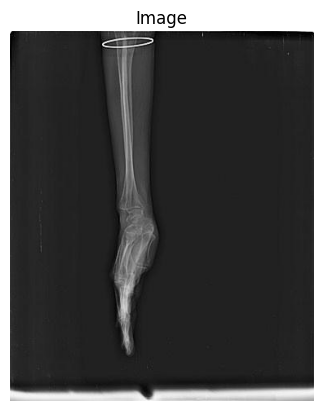

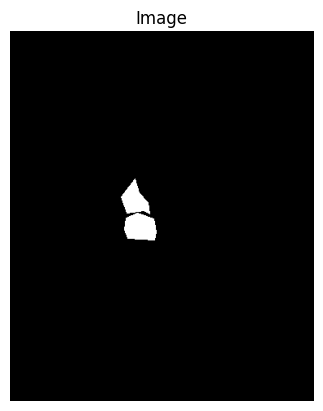

In [ ]:
# show_image(img),
# show_image(mask[:,:,1])

In [30]:
def process_images_and_labels(image_dir, json_dir, annotation_dir, dataset, image_size=(512, 512), test_size=0.2, random_state=42):
    """
    주어진 이미지 디렉토리와 어노테이션 파일을 처리하여 훈련 데이터와 레이블을 생성하는 함수.

    Parameters:
        image_dir (str): 이미지 파일들이 저장된 디렉토리 경로.
        json_dir (str): JSON 형식의 마스크 파일들이 저장된 디렉토리 경로.
        annotation_dir (str): YOLO 어노테이션 파일들이 저장된 디렉토리 경로.
        dataset (DataFrame): 이미지 ID를 포함하는 pandas DataFrame. 'image_id' 칼럼을 사용하여 처리.
        image_size (tuple): 리사이즈할 이미지 크기 (디폴트는 (512, 512)).
        test_size (float): 훈련 데이터와 검증 데이터의 분할 비율 (디폴트는 0.2).
        random_state (int): 랜덤 시드 값 (디폴트는 42).

    Returns:
        x_train (numpy.ndarray): 훈련 이미지 데이터.
        x_val (numpy.ndarray): 검증 이미지 데이터.
        y_train (numpy.ndarray): 훈련 레이블 데이터.
        y_val (numpy.ndarray): 검증 레이블 데이터.
    """
    images = []  # 처리된 이미지들을 저장할 리스트
    label_images = []  # 처리된 레이블 이미지를 저장할 리스트

    # 데이터셋에서 ID 칼럼을 사용해 이미지와 어노테이션을 처리
    for idx in dataset['image_id']:
        image_id = idx.split('.')[0]  # 'IMG000001.jpg'에서 'IMG000001'만 추출
        image_file = f"{image_id}.jpg"  # 이미지 경로 생성
        
        # 이미지와 마스크 처리
        img = open_image(image_dir, image_file)  # 이미지 열기
        sharpened_img = sharpen_image(img)  # 샤프닝 처리
        normalized_image = normalize_image(sharpened_img)  # 정규화

        
        mask = crate_mask_image(image_dir, json_dir, image_file)  # 마스크 이미지 생성
        
        # 리사이즈 및 샤프닝
        processed_images = resize_images(normalized_image, target_size=image_size)
        processed_label_images = prepare_labels(mask, image_size)
        
        # 결과 리스트에 추가
        images.extend(processed_images)
        label_images.extend(processed_label_images)
        
    images = np.array(images)  # 이미지 리스트를 numpy 배열로 변환
    label_images = np.array(label_images)  # 레이블 이미지 리스트를 numpy 배열로 변환
        
    # 학습/검증 데이터로 분할
    x_train, x_val, y_train, y_val = train_test_split(images, label_images, test_size=test_size, random_state=random_state)

    # 레이블 검증 및 필요시 이진화
    unique_train = np.unique(y_train)
    unique_val = np.unique(y_val)

    if len(set(unique_train) - {0, 1}) > 0 or len(set(unique_val) - {0, 1}) > 0:
        print("경고: 레이블에 0과 1 이외의 값이 포함되어 있습니다. 레이블 준비를 수행합니다.")
        y_train, y_val = prepare_and_count_labels(y_train, y_val)
    else:
        print("레이블이 이미 이진화되어 있습니다 (0과 1만 포함).")

    # 크기 확인 및 불일치 시 처리
    x_train = np.squeeze(x_train)
    x_val = np.squeeze(x_val)
    y_train = np.squeeze(y_train)
    y_val = np.squeeze(y_val)

    # 데이터 크기 출력
    print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
    print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
    
    return x_train, x_val, y_train, y_val  # 훈련 및 검증 데이터 반환

In [ ]:
import pandas as pd

# 이미지, JSON, 어노테이션 디렉토리 경로 설정
image_dir = 'FracAtlas/images/Fractured'  # 이미지가 저장된 디렉토리 경로
json_dir = 'FracAtlas/Annotations/VGG JSON/VGG_fracture_masks.json'  # JSON 형식의 마스크 파일 경로
annotation_dir = 'FracAtlas/Annotations/YOLO'  # YOLO 어노테이션 파일이 저장된 디렉토리 경로

# 데이터셋 CSV 파일을 읽어 pandas DataFrame으로 로드
df = pd.read_csv('FracAtlas/dataset.csv')

# 'fractured' 칼럼 값이 1인 이미지들만 선택하여 데이터셋 필터링
dataset = df[df['fractured'] == 1]

# 이미지를 처리하고 훈련 및 검증 데이터를 분리하는 함수 호출
# 이미지 디렉토리, JSON 디렉토리, YOLO 어노테이션 디렉토리와 데이터를 인자로 전달
x_train, x_val, y_train, y_val = process_images_and_labels(image_dir, json_dir, annotation_dir, dataset, image_size=(256, 256), test_size=0.2, random_state=42)

# 훈련 데이터와 검증 데이터를 npy 파일 형식으로 저장
# x_train과 y_train을 각각 'x_train.npy', 'y_train.npy'로 저장
save_data_as_npy(x_train, y_train, '2024_12_07_x_train.npy', '2024_12_07_y_train.npy')

# x_val과 y_val을 각각 'x_val.npy', 'y_val.npy'로 저장
save_data_as_npy(x_val, y_val, '2024_12_07_x_val.npy', '2024_12_07_y_val.npy')

(2880, 2304)
(2880, 2304)
(2304, 2880)
(2304, 2880)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2880, 2304)
(2140, 1760)
(2140, 1760)
(373, 454)
(373, 454)
(454, 373)
(454, 373)
(373, 454)
(373, 454)
(373, 454)
(373, 454)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(373, 454)
(373, 454)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(373, 454)
(373, 454)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 373)
(454, 3

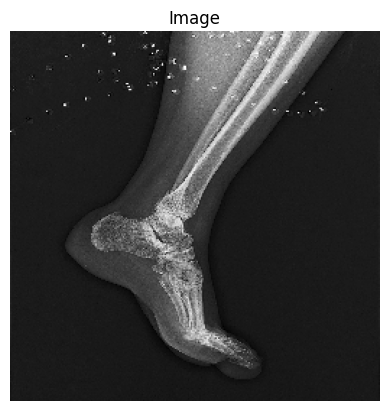

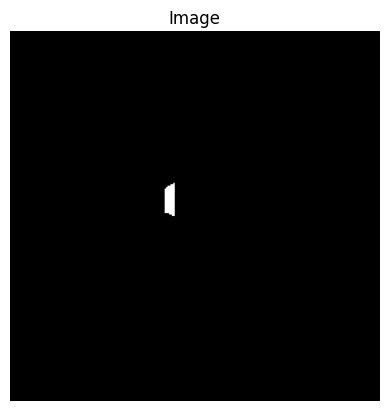

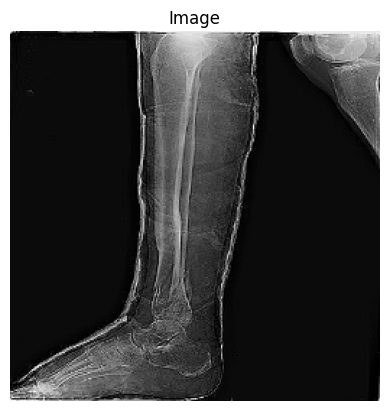

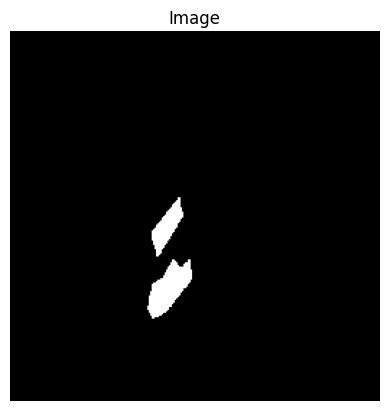

In [32]:
show_image(x_train[1]),
show_image(y_train[1][:,:,1])
show_image(x_val[1]),
show_image(y_val[1][:,:,1])

In [10]:
import tensorflow as tf
import gc

# TensorFlow 세션 종료
tf.keras.backend.clear_session()

# Python의 가비지 컬렉터 호출 (메모리 해제)
gc.collect()

11240